<a href="https://colab.research.google.com/github/rand-albej/mnist_vae/blob/main/mnist_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary

In [ ]:
# MNIST
trainset = MNIST(root='data/', train=True, download=True, transform=transforms.ToTensor())
batch_sz = 64
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_sz, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 61404520.37it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 14332192.83it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23419327.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16408724.18it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
class VarAutoEncoder(nn.Module):
  def __init__(self, nz=32):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(1, 16, 3, 2, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32,64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*4*4, 128)
    self.ebn4 = nn.BatchNorm1d(128)

    self.dlinear1 = nn.Linear(nz,128)
    self.dbn1 = nn.BatchNorm1d(128)
    self.dlinear2 = nn.Linear(128,64*4*4)
    self.dbn2 = nn.BatchNorm2d(64)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding =1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding =1)

    self.ulinear = nn.Linear(128,nz)
    self.slinear = nn.Linear(128,nz)

  def encoder (self,x):
    x = F.leaky_relu(self.econv1(x))
    x = self.ebn1(x)
    x = F.leaky_relu(self.econv2(x))
    x = self.ebn2(x)
    x = F.leaky_relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1,64*4*4)
    x = F.leaky_relu(self.elinear1(x))
    x = self.ebn4(x)
    return x

  def decoder(self, x):
    x = F.leaky_relu(self.dlinear1(x))
    x = self.dbn1(x)
    x = F.leaky_relu(self.dlinear2(x))
    x = x.view(-1, 64,4,4)
    x = self.dbn2(x)
    x = F.leaky_relu(self.dconv1(x))
    x = self.dbn3(x)
    x = F.leaky_relu(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x

  def get_params(self,x):
    u = self.ulinear(x)
    logvar = self.slinear(x)
    return u, logvar

  def reparametarization(self, u, logvar):
    std = torch.exp(logvar/2)
    z = u + std*torch.randn_like(u)
    return z

  def forward(self,x):
    ex = self.encoder(x)
    u, logvar = self.get_params(ex)
    z = self.reparametarization(u, logvar)
    x = self.decoder(z)
    return ex,z, x, u, logvar

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = VarAutoEncoder(32).to(device)

summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
            Conv2d-3             [-1, 32, 7, 7]           4,640
       BatchNorm2d-4             [-1, 32, 7, 7]              64
            Conv2d-5             [-1, 64, 4, 4]          18,496
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Linear-7                  [-1, 128]         131,200
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                   [-1, 32]           4,128
           Linear-10                   [-1, 32]           4,128
           Linear-11                  [-1, 128]           4,224
      BatchNorm1d-12                  [-1, 128]             256
           Linear-13                 [-1, 1024]         132,096
      BatchNorm2d-14             [-1, 6

0 168.06086611747742
1 81.08185765892267
2 59.46237837523222
3 50.356123477220535
4 45.93857675790787
5 43.51391213387251
6 41.87294478341937
7 40.72365501150489
8 39.81777537614107
9 39.08420502766967


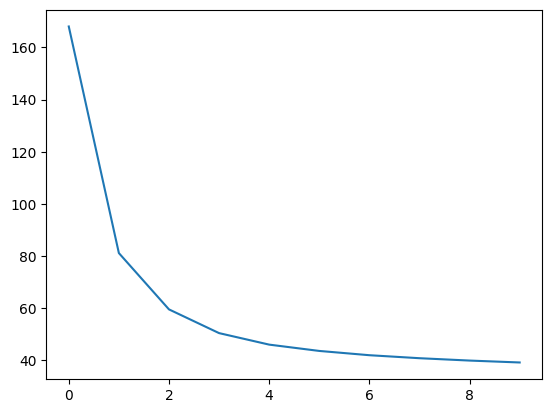

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"
net = VarAutoEncoder(32).to(device)

num_epochs = 10   # smaller if too slow
lr = 1e-4

optimizer = optim.Adam(net.parameters(), lr = lr)
ls = []

def vae_loss(Xhat, X, u, logvar):
  KLD_WEIGHT = 0.0012
  term1 = F.mse_loss(Xhat, X)
  term2 = torch.mean(torch.sum(0.5*(1+logvar - torch.exp(logvar) - u**2), axis = 1), axis =0)
  return (1- KLD_WEIGHT)* term1 - KLD_WEIGHT*term2

for epoch in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    ex, z,Xhat, u, logvar = net(X)
    loss = vae_loss(Xhat, X,u, logvar )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(epoch, total_loss)

  ls.append(total_loss)

plt.plot(ls)


In [ ]:
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
            Conv2d-3             [-1, 32, 7, 7]           4,640
       BatchNorm2d-4             [-1, 32, 7, 7]              64
            Conv2d-5             [-1, 64, 4, 4]          18,496
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Linear-7                  [-1, 128]         131,200
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                   [-1, 32]           4,128
           Linear-10                   [-1, 32]           4,128
           Linear-11                  [-1, 128]           4,224
      BatchNorm1d-12                  [-1, 128]             256
           Linear-13                 [-1, 1024]         132,096
      BatchNorm2d-14             [-1, 6

In [ ]:
print(Xhat.shape)

torch.Size([32, 1, 28, 28])


In [ ]:
net.eval()
z = torch.randn(64,32)
Xhat = net.decoder(z)


torch.Size([64, 1, 28, 28]) torch.Size([28, 28]) torch.float32


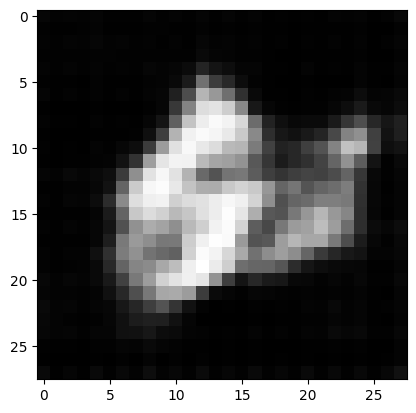

In [ ]:
img = Xhat[0, 0]
print(Xhat.shape, img.shape, img.dtype)
plt.imshow(img.detach().cpu().numpy(), cmap='gray')


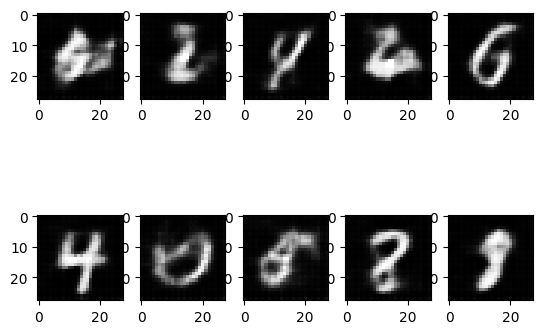

In [ ]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(Xhat[i,0,:,:].detach().cpu().numpy(),cmap='gray')


In [ ]:
# save the model
PATH = './mnist_gen_net.pth'
torch.save(net.state_dict(), PATH)
# the below lines will load the model
# net = Net()
# net.load_state_dict(torch.load(PATH))